# Hackathon 1: descriptive statistics, estimation and bootstrapping

This project illustrates the course LEPL1109 with an industrial applications of statistics. You will analyse the performance of wind farms located in the Walloon Brabant near Beauvechain and in the high Fens, close to Elsenborn. Each wind farm exploits 8 wind turbines. The kinetic power, noted Pk, (in watt) of one wind turbine is calculated with the formula 

Pk (W) = 0.5 x Rho x S x V^3

Where 

S   : is the surface of the circle in square meters with a radius equal to the length of blades (32 m).
Rho : is the air density (“masse volumique”). We consider here an average value of 1.2 kg/m^3
V   : is the speed of wind in m/s.

According to the Betz limit, only 59.3% of the kinetic energy from wind can be used to spin the turbine and generate electricity. In reality, turbines cannot reach the Betz limit, and the efficiency is estimated to 42% of the kinetic power. One wind turbine generates an electric power Pe = 0.42 x Pk. 

The wind turbins are stopped if the wind speed is above 90 km/h.

The file “BeauvechainWind.csv” and “Elsenborn.csv” contains the average daily wind speeds, measured in km/h, at Beauvechain and  Elsenborn (source www. https://www.ecad.eu/)

FILE FORMAT (MISSING VALUE CODE IS -9999):
01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 FG   : wind speed in 0.1 m/s
23-27 Q_FG : Quality code for FG (0='valid'; 1='suspect'; 9='missing')


## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Emile VILLETTE (10992000)

Part. 2: Brieuc DUBOIS (23752000)

Part. 3: Romain BARBASON (22142000)

Part. 4: Tania SHAFIEI (17451800)

Part. 5: Guillaume JADIN (10581800)

Part. 6: Nicolas JEANMENNE (48741900)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from datetime import datetime
from scipy import stats
import seaborn as sns
sns.set()

In [2]:
def Pk(V):
    return 0.5 * 1.2 * (math.pi * (32 ** 2)) * ((V/3.6) ** 3) * 8


def Pe(Pk):
    return 0.42 * Pk


def open_csv(filename):
    return pd.read_csv(filename, parse_dates=['DATE'], skipinitialspace=True)


def select_correct_data(data):
    return data[(data.FG > 0) & ((data.Q_FG != 1) & (data.Q_FG != 9))]

In [3]:
df_be = select_correct_data(open_csv('Beauvechain.csv'))
df_el = select_correct_data(open_csv('Elsenborn.csv'))
df_be = df_be[(datetime(2017, 1, 1) <= df_be['DATE']) & (df_be['DATE'] <= datetime(2021, 1, 1))]
df_el = df_el[(datetime(2017, 1, 1) <= df_el['DATE']) & (df_el['DATE'] <= datetime(2021, 1, 1))]
cdv = np.intersect1d(df_be['DATE'].values, df_el['DATE'].values)
df_be = df_be[df_be['DATE'].isin(cdv)]
df_el = df_el[df_el['DATE'].isin(cdv)]

------------------------------------------------------------------------------------------------------
1.	Write a function computing the electric power capacity (in Mega Watts = 10^6 W), for the two wind farms using wind data from the 1/1/2017 to the 1/1/2021

•	Do not forget to set the production to zero if the wind speed is above 90 km. 

•	Take care to converts units.

•	Remove all days with missing data (error code 1 or 9) for Beauvechain or Elsenborn

------------------------------------------------------------------------------------------------------

In [4]:
df_be['PowerCapacity'] = Pe(Pk(df_be['FG'])) * (10) ** -6
df_el['PowerCapacity'] = Pe(Pk(df_el['FG'])) * (10) ** -6

In [5]:
df_be.loc[df_be['FG'] >= 90, 'PowerCapacity'] = 0
df_el.loc[df_el['FG'] >= 90, 'PowerCapacity'] = 0

In [6]:
df_pcd = df_be.set_index('DATE')[['PowerCapacity']].join(df_el.set_index('DATE')[['PowerCapacity']], lsuffix='_be', rsuffix='_el')
df_pcd.columns = ['Beauvechain power capacity', 'Elsenborn power capacity']
df_pcd

,Beauvechain power capacity,Elsenborn power capacity
DATE,,
2017-01-01,23.127086,0.810682
2017-01-02,3.390212,2.736051
2017-01-03,21.888406,9.580417
2017-01-04,19.545325,33.128969
2017-01-05,1.691283,5.463483
...,...,...
2020-12-28,2.443166,4.141121
2020-12-29,5.959873,2.736051
2020-12-30,7.041060,2.736051


Comment briefly your results:
To obtain these results, we used the Pandas Python library to generate a dataframe that is easy to work with. It contains the days that produced results for both wind farms. The table here-above is pretty self-explanatory and simply presents the data that we obtained after filtering out invalid measurements.

------------------------------------------------------------------------------------------------------------------------

2.	Plot histograms and box plots of electric power capacity (MW) from the 1/1/2017 to the 1/1/2021 (both sites). 

------------------------------------------------------------------------------------------------------------------------

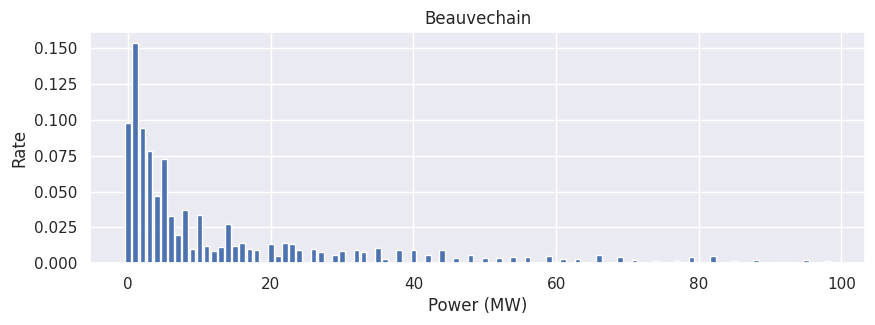

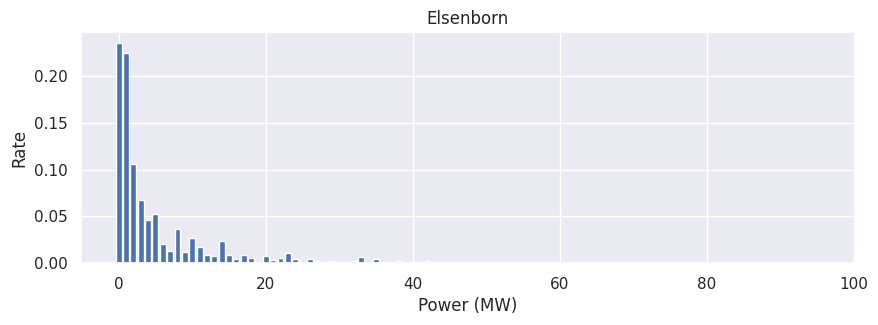

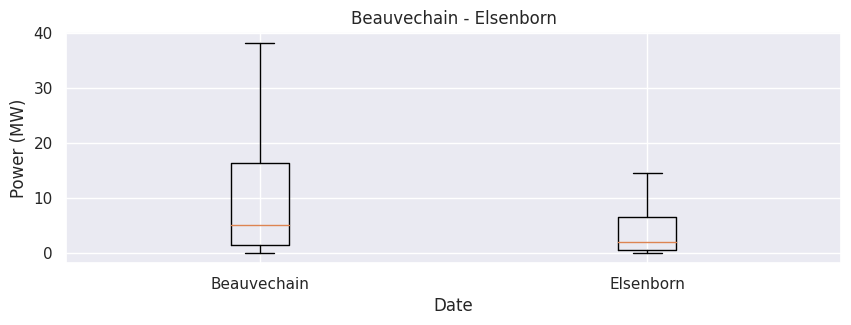

In [7]:
#histogram of electric power capacities in the given periode
def q2_histogram(df, title=''):
    df_pcc = df.groupby(df['PowerCapacity'].round())['FG'].count()
    plt.figure(figsize=(10, 3))
    plt.title(title)
    plt.bar(df_pcc.index, df_pcc.values / df_pcc.sum())
    plt.ylabel('Rate')
    plt.xlabel('Power (MW)')

def q2_boxplot(df, df2, title='', ticks='', labels=''):
    plt.figure(figsize=(10, 3))
    plt.title(title)
    plt.boxplot([df['PowerCapacity'], df2['PowerCapacity']] ,showfliers=False)
    plt.xticks(ticks=ticks, labels=labels)
    plt.ylabel('Power (MW)')
    plt.xlabel('Date')


q2_histogram(df_be, title='Beauvechain')
q2_histogram(df_el, title='Elsenborn')
q2_boxplot(df_be, df_el, title='Beauvechain - Elsenborn', ticks=(1, 2), labels=('Beauvechain', 'Elsenborn'))

With an approximate interpretation of the obtained graphs, we can observe that the Beauvechain wind farm seems to have a higher rolling average than the Elsenborn wind farm. The box plot helps to illustrate this tendency, where the median and upper quartiles are higher in Beauvechain than in Elsenborn.
Overall, we observe that the spikes and dips in power production appear to be "synced up" between the two farms, which is a coherent given their geographical proximity (approx. 110 km).

------------------------------------------------------------------------------------------------------

3.	Compare the following statistics of both sites and draw a first conclusions

•	Average and median powers for each farm (MW)

•	Standard deviations of powers, for each farm (MW)

•	5% and 95% percentiles of powers, for each farm (MW)

The average and standard deviation of the total power capacities (Beauvechain + Elsenborn).

------------------------------------------------------------------------------------------------------

In [8]:
def q3(df, name=""):
    print(f"{name} farm:")
    print(f" - Average power: {df['PowerCapacity'].mean():.2f} MW")
    print(f" - Median power: {df['PowerCapacity'].median():.2f} MW")
    print(f" - Standard deviation: {df['PowerCapacity'].std():.2f} MW")
    print(f" - Percentile 5: {np.percentile(df['PowerCapacity'], 5):.2f} MW")
    print(f" - Percentile 95: {np.percentile(df['PowerCapacity'], 95):.2f} MW")

q3(df_be, "Beauvechain")
print()
q3(df_el, "Elsenborn")
print()
dfc = df_be.copy()
dfc['PowerCapacity'] += df_el['PowerCapacity'].values
q3(dfc, "Both")

Beauvechain farm:
 - Average power: 12.60 MW
 - Median power: 5.00 MW
 - Standard deviation: 17.84 MW
 - Percentile 5: 0.24 MW
 - Percentile 95: 54.08 MW

Elsenborn farm:
 - Average power: 5.65 MW
 - Median power: 1.92 MW
 - Standard deviation: 9.77 MW
 - Percentile 5: 0.10 MW
 - Percentile 95: 23.13 MW

Both farm:
 - Average power: 18.25 MW
 - Median power: 7.67 MW
 - Standard deviation: 24.40 MW
 - Percentile 5: 0.64 MW
 - Percentile 95: 76.15 MW


We can observe that Beauvechain has a higher average, median, standard deviation and percentiles(5 and 95) than Elsenborn.
This is coherent with the previous question's results where Beauvechain shows a higher overal production than Elsenborn.
The aggregated results for both farms are also consistent with the ones for each farm.


------------------------------------------------------------------------------------------------------
4.	Fit Gamma and Inverse Gaussian distributions to wind speeds (in Km/h) in Beauvechain and Elsenborn. Estimate their parameters by log-likelihood maximization (MLE). Which distribution is the best one? Compare the histograms of winds with the fitted pdf’s on the same plot.
------------------------------------------------------------------------------------------------------

Log-likelihood maximization:

 Beauvechain:
 - Gamma: 2.069
 - Invgauss: 2.066

 Elsenborn:
 - Gamma: 2.472
 - Invgauss: 2.469


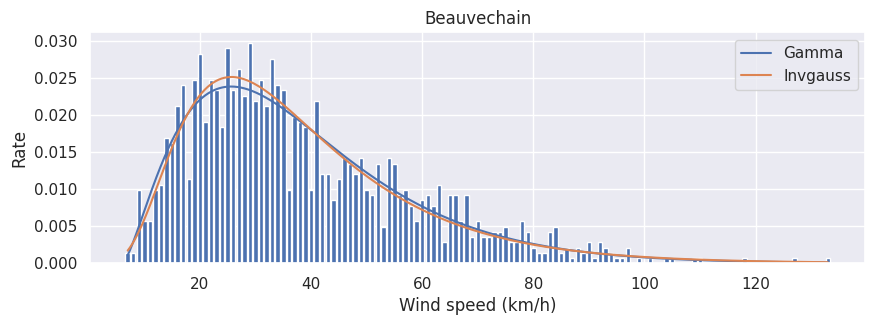

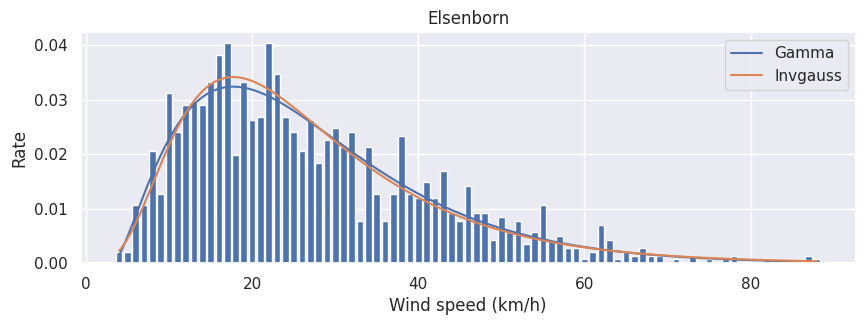

In [9]:
dists = [stats.gamma, stats.invgauss]

def q4(df, *fcts, title=''):
    df_fgc = df.groupby(['FG'])['PowerCapacity'].count()

    plt.figure(figsize=(10, 3))
    plt.title(title)
    plt.xlabel('Wind speed (km/h)')
    plt.ylabel('Rate')
    plt.bar(df_fgc.index, df_fgc.values / df_fgc.sum())
    
    aparams = {}
    
    print(f' {title.capitalize()}:')
    
    for fct in fcts:
        X = np.linspace(df['FG'].min(), df['FG'].max(), 1000)
        params = fct.fit(df['FG'].values)
        y = fct.pdf(X, *params)
        
        mle = np.log(y.sum())
        
        print(f' - {fct.name.capitalize()}: {mle:.3f}')
        
        aparams[fct] = params
        
        plt.plot(X, y, label=fct.name.capitalize())
    plt.legend()
    
    return aparams

print('Log-likelihood maximization:\n')

be_params = q4(df_be, *dists, title='Beauvechain')
print()
el_params = q4(df_el, *dists, title='Elsenborn')

Both the gamma and the inverse Gaussian fit the data. The inverse Gaussian has a slightly higher mle in both cases.

------------------------------------------------------------------------------------------------------
5.	Compute numerically for both sites, the following statistics 

•	Expected and median powers for each farm (MW)

•	Standard deviation of powers for each farm (MW)

•	5% and 95% percentiles of powers for each farm (MW)

Use the best distributions fitted in Question 4 (not observed values)

------------------------------------------------------------------------------------------------------

In [10]:
best_fct = stats.invgauss

def q5(fct, params, name=""):
    sample_ws = fct.rvs(*params, 1000000)
    sample_pw = Pe(Pk(sample_ws)) * 10**-6
    sample_pw[sample_ws >= 90] = 0
    
    print(f"{name} farm:")
    print(f" - Theorical average power: {sample_pw.mean():.2f} MW")
    print(f" - Theorical median power: {np.median(sample_pw):.2f} MW")
    print(f" - Theorical standard deviation: {np.std(sample_pw):.2f} MW")
    print(f" - Theorical percentile 5: {np.percentile(sample_pw, 5):.2f} MW")
    print(f" - Theorical percentile 95: {np.percentile(sample_pw, 95):.2f} MW")
    
    return sample_pw

_ = q5(best_fct, be_params[best_fct], "Beauvechain")
print()
_ = q5(best_fct, el_params[best_fct], "Elsenborn")

Beauvechain farm:
 - Theorical average power: 11.59 MW
 - Theorical median power: 4.84 MW
 - Theorical standard deviation: 16.83 MW
 - Theorical percentile 5: 0.21 MW
 - Theorical percentile 95: 49.02 MW

Elsenborn farm:
 - Theorical average power: 5.53 MW
 - Theorical median power: 1.84 MW
 - Theorical standard deviation: 10.42 MW
 - Theorical percentile 5: 0.09 MW
 - Theorical percentile 95: 23.94 MW


Comment briefly your results

The results we observe are similar to the results in Q3. To obtain these results, we sample 1.000.000 points from the gamma distribution in Q4 and compute the average, median, standard deviation and percentiles from that.

------------------------------------------------------------------------------------------------------

6.	Same question as Q.4 but this time, you fit the best distribution by the methods of moments MM, (in Python). Compare parameter estimates and plot pdf’s obtained by MLE and MM for both wind farms.

------------------------------------------------------------------------------------------------------

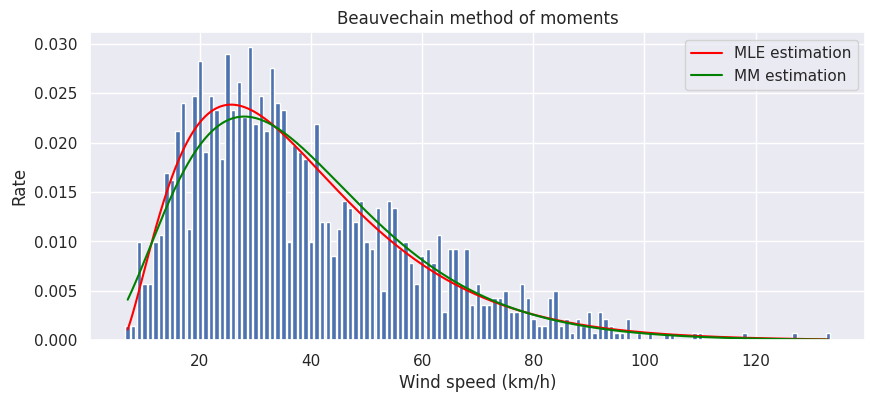

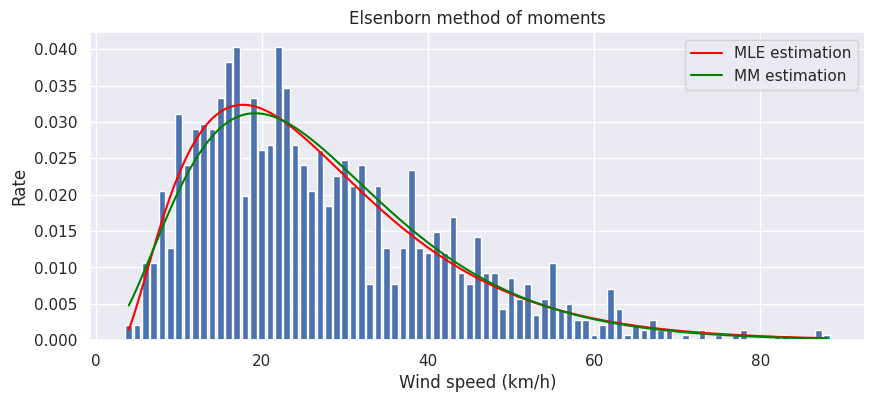

In [11]:
#code here
def sample_moment(sample, n):
    sm = np.sum([nb**n for nb in sample])
    lgt = len(sample)
    return 1/lgt * sm

def estimate(sample):
    first_moment = sample_moment(sample,1)
    second_moment = sample_moment(sample,2)
    k = first_moment**2/(second_moment - first_moment**2)
    theta = second_moment/first_moment - first_moment
    return k, theta



def q6(df, title=''):
    df_fgc = df.groupby(['FG'])['PowerCapacity'].count()
    X = np.linspace(df["FG"].min(), df["FG"].max(), 1000)

    #method of moments
    k_chapeau , theta_chapeau = estimate(df["FG"].values)
    y_mm = stats.gamma.pdf(x=X, a= k_chapeau, scale=theta_chapeau)

    #MLE method
    params = stats.gamma.fit(df['FG'].values)
    y_mle = stats.gamma.pdf(X, *params)

    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.xlabel('Wind speed (km/h)')
    plt.ylabel('Rate')
    plt.bar(df_fgc.index, df_fgc.values / df_fgc.sum())
    plt.plot(X, y_mle, color="red", label="MLE estimation")
    plt.plot(X, y_mm, color='green', label="MM estimation")
    plt.legend()

mm_be = q6(df_be, title="Beauvechain method of moments")
mm_el = q6(df_el, title="Elsenborn method of moments")


------------------------------------------------------------------------------------------------------

7.	Bootstrap 1000 times a sample of 500 daily speeds of wind for both wind farms and compute a 5% confidence interval for parameter(s) estimates for the best distribution of Question 4) modelling winds in Beauvechain. How do you interpret the results

------------------------------------------------------------------------------------------------------

In [12]:
from scipy.stats import gamma
import random as rn
import os

def log_likelihood_gam(data, alpha, beta):
    retval = 0
    for x in data:
        retval += np.log(gamma.pdf(x,a=alpha,scale=beta))
    return retval

def q7(df):
    speed_wind_be = df['FG'].values
    params_be = {'beta':[], 'alpha':[]}

    for m in np.arange(0, 1000):
        drand_be = rn.choices(population=speed_wind_be, k=500)
        gamm_be = gamma.fit(data=drand_be, scale=1, floc=0)
        
        params_be['alpha'].append(gamm_be[0])
        params_be['beta'].append(gamm_be[2])

    alpha_be = (np.quantile(params_be['alpha'], q=0.025), np.quantile(params_be['alpha'], q=0.975))
    beta_be = (np.quantile(params_be['beta'], q=0.025), np.quantile(params_be['beta'], q=0.975))

    print("Beauvechain:")
    print(f" - Alpha confidence interval 5%: [{alpha_be[0]:.3f} ; {alpha_be[1]:.3f}]")
    print(f" - Beta confidence interval 5%: [{beta_be[0]:.3f} ; {beta_be[1]:.3f}]")

q7(df_be)

Beauvechain:
 - Alpha confidence interval 5%: [3.511 ; 4.301]
 - Beta confidence interval 5%: [8.832 ; 11.070]


------------------------------------------------------------------------------------------------------

8.	Let us denote by X the wind speed observed at Beauvechain on a day of the year. The winds observed over 30 days are denoted by (X1,…,X30). They are realizations of X, a random variable with the distribution fitted in Question 4. If M=max{ X1,…,X30},  

•	find the statistical law of M (equation requested, hint use the cdf of X) 

•	plot the pdf and cdf of M. 

•	Determine the wind value, p5, such that  P(M>p5)=95%.


------------------------------------------------------------------------------------------------------

In [13]:
dfm = df_be.groupby(pd.Grouper(freq='M', key='DATE', how='max')).max()

In [14]:
dm = {df_be['DATE'].iloc[i]: df_be['FG'].iloc[i:i+30].max() for i in range(0, len(df_be), 30)}

In [15]:
y = df_be['FG'].rolling(window=30).max()

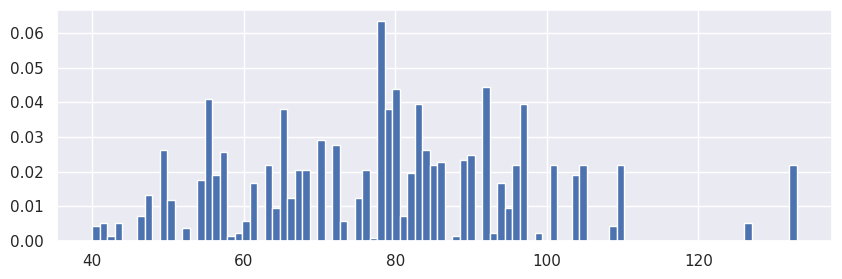

In [16]:
plt.figure(figsize=(10, 3))
_ = plt.hist(y, bins=int(y.max()-y.min()+1), density=True)

ValueError: `bins` must increase monotonically, when an array

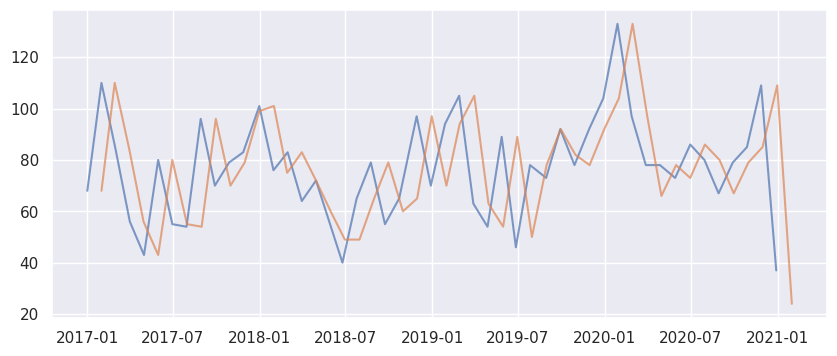

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(dm.keys(), dm.values(), alpha=0.7, label='by month')
plt.plot(dfm.index, dfm['FG'], alpha=0.7, label='by 30 days')
plt.plot(df_be['DATE'], df_be['FG'].rolling(window=30).max(), alpha=0.7, label='Rolling max')
plt.ylim((0, 140))
plt.legend()

We can obtain the distribution of $M=max\{X_1,X_2,...,X_n\}$ from $F_X(x)$. Id est $F_n(y) = P[(X_1 \leq y) \cap (X_1 \leq y) \cap ... \cap (X_n \leq y)] = \{ F_X(y) \}^n$

In [26]:
print(stats.gamma.cdf(df_be["FG"].values))

TypeError: _parse_args() missing 1 required positional argument: 'a'

Comment briefly your results

